In [1]:

!pip install vaderSentiment
!pip install yfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.2 MB/s eta 0:00:00


In [8]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

news_df = pd.read_csv("/content/apple.news.csv")
stock_df = pd.read_csv("/content/appl.csv")
news_df['published_at'] = pd.to_datetime(news_df['published_at'], utc=True, errors='coerce', dayfirst=True)
news_df = news_df.dropna(subset=['published_at'])
news_df['Date'] = news_df['published_at'].dt.date
analyzer = SentimentIntensityAnalyzer()
news_df['Sentiment'] = news_df['headline'].astype(str).apply(lambda x: analyzer.polarity_scores(x)['compound'])
daily_sentiment = news_df.groupby('Date')['Sentiment'].mean().reset_index()
stock_df['Date'] = pd.to_datetime(stock_df['Date'], dayfirst=True).dt.date
merged_df = pd.merge(stock_df, daily_sentiment, on='Date', how='left')
merged_df['Sentiment'] = merged_df['Sentiment'].fillna(0)
print(merged_df.head())


         Date      Open      High       Low     Close  Adj Close     Volume  \
0  2000-01-03  0.936384  1.004464  0.907924  0.999442   0.855797  535796800   
1  2000-01-04  0.966518  0.987723  0.903460  0.915179   0.783644  512377600   
2  2000-01-05  0.926339  0.987165  0.919643  0.928571   0.795112  778321600   
3  2000-01-06  0.947545  0.955357  0.848214  0.848214   0.726304  767972800   
4  2000-01-07  0.861607  0.901786  0.852679  0.888393   0.760708  460734400   

   Sentiment  
0     0.0000  
1     0.4767  
2     0.0000  
3     0.0000  
4    -0.6486  


In [13]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
stock_df = pd.read_csv('/content/appl.csv')
news_df = pd.read_csv('/content/apple.news.csv')
stock_df['Date'] = pd.to_datetime(stock_df['Date'], dayfirst=True, errors='coerce')
news_df['published_at'] = pd.to_datetime(news_df['published_at'], errors='coerce')
news_df['Date'] = news_df['published_at'].dt.date
news_df['Date'] = pd.to_datetime(news_df['Date'])
news_df = news_df.dropna(subset=['headline', 'Date'])
analyzer = SentimentIntensityAnalyzer()
news_df['Sentiment'] = news_df['headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
daily_sentiment = news_df.groupby('Date')['Sentiment'].mean().reset_index()
merged_df = pd.merge(stock_df, daily_sentiment, on='Date', how='left')
merged_df['Sentiment'].fillna(0, inplace=True)
merged_df['Sentiment_lag1'] = merged_df['Sentiment'].shift(1).fillna(0)
merged_df['Sentiment_rolling3'] = merged_df['Sentiment'].rolling(window=3).mean().fillna(0)
merged_df['Sentiment_pos'] = (merged_df['Sentiment'] > 0).astype(int)
merged_df['Sentiment_neg'] = (merged_df['Sentiment'] < 0).astype(int)
features_traditional = ['Open', 'High', 'Low', 'Volume']
features_hybrid = features_traditional + ['Sentiment', 'Sentiment_lag1', 'Sentiment_rolling3', 'Sentiment_pos', 'Sentiment_neg']
scaler = StandardScaler()
X_traditional_scaled = scaler.fit_transform(merged_df[features_traditional])
X_hybrid_scaled = scaler.fit_transform(merged_df[features_hybrid])
y = merged_df['Close']
X_train_t, X_test_t, y_train, y_test = train_test_split(X_traditional_scaled, y, test_size=0.2, random_state=42)
X_train_h, X_test_h, _, _ = train_test_split(X_hybrid_scaled, y, test_size=0.2, random_state=42)
rf_traditional = RandomForestRegressor(random_state=42, n_estimators=200, max_depth=10)
rf_hybrid = RandomForestRegressor(random_state=42, n_estimators=200, max_depth=10)
rf_traditional.fit(X_train_t, y_train)
rf_hybrid.fit(X_train_h, y_train)
rf_pred_t = rf_traditional.predict(X_test_t)
rf_pred_h = rf_hybrid.predict(X_test_h)
rmse_traditional = np.sqrt(mean_squared_error(y_test, rf_pred_t))
rmse_hybrid = np.sqrt(mean_squared_error(y_test, rf_pred_h))
print(f"Random Forest RMSE Traditional: {rmse_traditional:.4f}")
print(f"Random Forest RMSE Hybrid: {rmse_hybrid:.4f}")


<ipython-input-13-fbc462898536>:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Sentiment'].fillna(0, inplace=True)


Random Forest RMSE Traditional: 0.5647
Random Forest RMSE Hybrid: 0.5622


Random Forest RMSE Traditional: 0.5647
Random Forest RMSE Hybrid: 0.5622


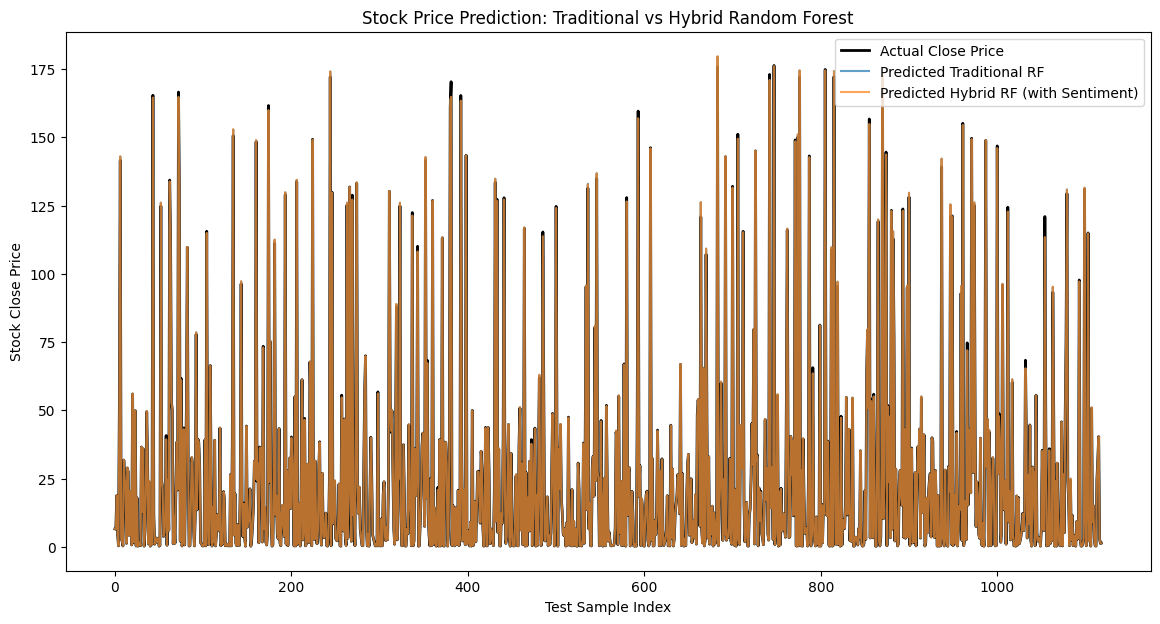

In [15]:
import matplotlib.pyplot as plt


print(f"Random Forest RMSE Traditional: {rmse_traditional:.4f}")
print(f"Random Forest RMSE Hybrid: {rmse_hybrid:.4f}")
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual Close Price', color='black', linewidth=2)
plt.plot(rf_pred_t, label='Predicted Traditional RF', alpha=0.7)
plt.plot(rf_pred_h, label='Predicted Hybrid RF (with Sentiment)', alpha=0.7)

plt.title('Stock Price Prediction: Traditional vs Hybrid Random Forest')
plt.xlabel('Test Sample Index')
plt.ylabel('Stock Close Price')
plt.legend()
plt.show()


<ipython-input-16-dda66984c501>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Sentiment'].fillna(0, inplace=True)


Random Forest RMSE Traditional: 0.5647
Random Forest RMSE Hybrid: 0.5622


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
LSTM RMSE Traditional: 31.1650
LSTM RMSE Hybrid: 7.6377


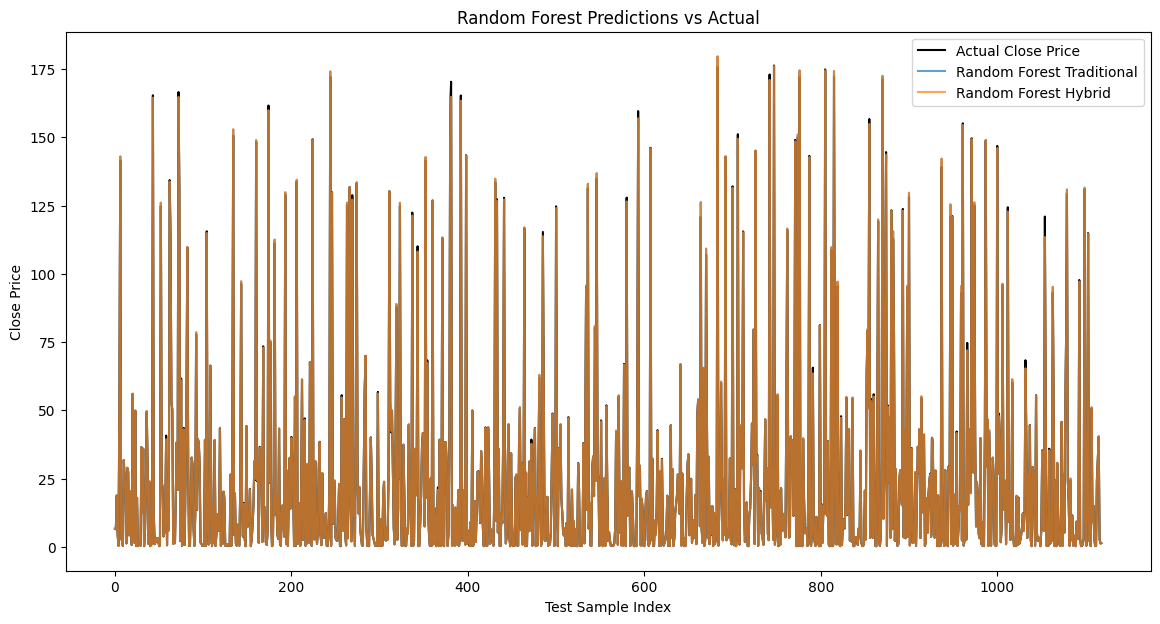

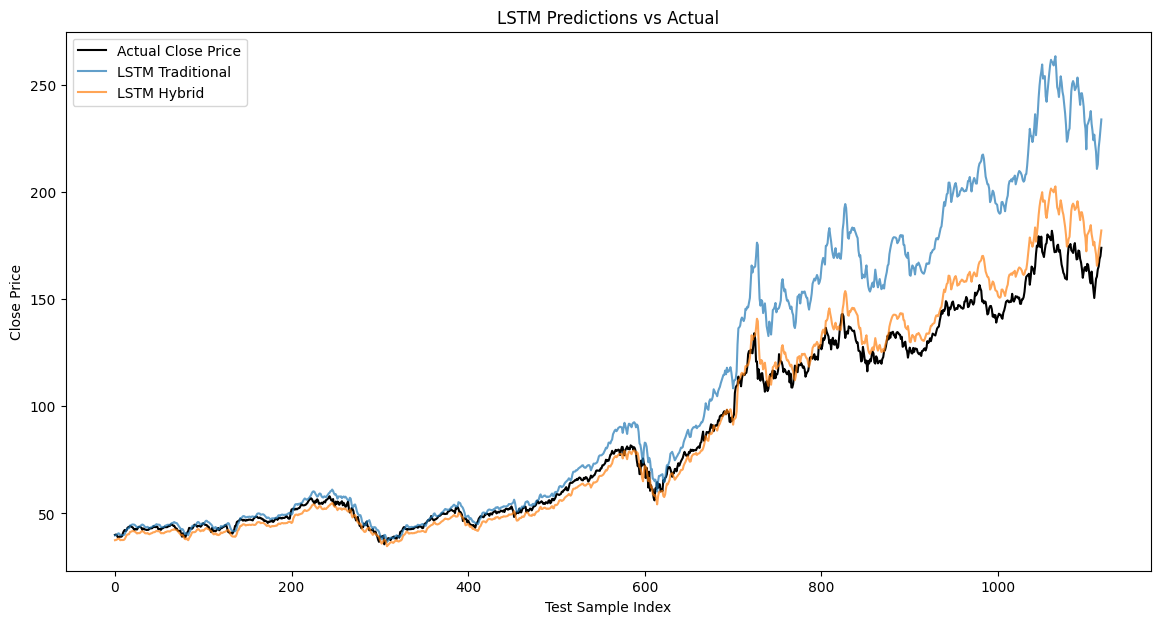

In [16]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

stock_df = pd.read_csv('/content/appl.csv')  # Stock data
news_df = pd.read_csv('/content/apple.news.csv')  # News data

stock_df['Date'] = pd.to_datetime(stock_df['Date'], dayfirst=True, errors='coerce')
news_df['published_at'] = pd.to_datetime(news_df['published_at'], errors='coerce')
news_df['Date'] = news_df['published_at'].dt.date
news_df['Date'] = pd.to_datetime(news_df['Date'])
news_df = news_df.dropna(subset=['headline', 'Date'])

analyzer = SentimentIntensityAnalyzer()
news_df['Sentiment'] = news_df['headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
daily_sentiment = news_df.groupby('Date')['Sentiment'].mean().reset_index()

merged_df = pd.merge(stock_df, daily_sentiment, on='Date', how='left')
merged_df['Sentiment'].fillna(0, inplace=True)

# Feature Engineering for hybrid model
merged_df['Sentiment_lag1'] = merged_df['Sentiment'].shift(1).fillna(0)
merged_df['Sentiment_rolling3'] = merged_df['Sentiment'].rolling(window=3).mean().fillna(0)
merged_df['Sentiment_pos'] = (merged_df['Sentiment'] > 0).astype(int)
merged_df['Sentiment_neg'] = (merged_df['Sentiment'] < 0).astype(int)

# Feature sets
features_traditional = ['Open', 'High', 'Low', 'Volume']
features_hybrid = features_traditional + ['Sentiment', 'Sentiment_lag1', 'Sentiment_rolling3', 'Sentiment_pos', 'Sentiment_neg']

# Prepare data for Random Forest (scaled)
scaler_rf = StandardScaler()
X_traditional_rf = scaler_rf.fit_transform(merged_df[features_traditional])
X_hybrid_rf = scaler_rf.fit_transform(merged_df[features_hybrid])
y_rf = merged_df['Close'].values

X_train_t_rf, X_test_t_rf, y_train_rf, y_test_rf = train_test_split(X_traditional_rf, y_rf, test_size=0.2, random_state=42)
X_train_h_rf, X_test_h_rf, _, _ = train_test_split(X_hybrid_rf, y_rf, test_size=0.2, random_state=42)

# Random Forest models
rf_traditional = RandomForestRegressor(random_state=42, n_estimators=200, max_depth=10)
rf_hybrid = RandomForestRegressor(random_state=42, n_estimators=200, max_depth=10)
rf_traditional.fit(X_train_t_rf, y_train_rf)
rf_hybrid.fit(X_train_h_rf, y_train_rf)
rf_pred_t = rf_traditional.predict(X_test_t_rf)
rf_pred_h = rf_hybrid.predict(X_test_h_rf)

rmse_rf_traditional = np.sqrt(mean_squared_error(y_test_rf, rf_pred_t))
rmse_rf_hybrid = np.sqrt(mean_squared_error(y_test_rf, rf_pred_h))

print(f"Random Forest RMSE Traditional: {rmse_rf_traditional:.4f}")
print(f"Random Forest RMSE Hybrid: {rmse_rf_hybrid:.4f}")

# ===== LSTM preparation =====
# LSTM requires 3D input: [samples, timesteps, features]
# For simplicity, let's create sequences with timesteps=1 (can increase for more context)

def create_lstm_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

scaler_lstm = MinMaxScaler()
X_traditional_lstm = scaler_lstm.fit_transform(merged_df[features_traditional])
X_hybrid_lstm = scaler_lstm.fit_transform(merged_df[features_hybrid])
y_lstm = merged_df['Close'].values

time_steps = 3  # use 3 days of history for prediction

X_t_lstm, y_t_lstm = create_lstm_dataset(X_traditional_lstm, y_lstm, time_steps)
X_h_lstm, y_h_lstm = create_lstm_dataset(X_hybrid_lstm, y_lstm, time_steps)

# Train/test split for LSTM
split_idx_t = int(len(X_t_lstm)*0.8)
split_idx_h = int(len(X_h_lstm)*0.8)

X_train_t_lstm, X_test_t_lstm = X_t_lstm[:split_idx_t], X_t_lstm[split_idx_t:]
y_train_t_lstm, y_test_t_lstm = y_t_lstm[:split_idx_t], y_t_lstm[split_idx_t:]

X_train_h_lstm, X_test_h_lstm = X_h_lstm[:split_idx_h], X_h_lstm[split_idx_h:]
y_train_h_lstm, y_test_h_lstm = y_h_lstm[:split_idx_h], y_h_lstm[split_idx_h:]

def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

model_traditional = build_lstm((time_steps, len(features_traditional)))
model_traditional.fit(X_train_t_lstm, y_train_t_lstm, epochs=20, batch_size=16, verbose=0)

model_hybrid = build_lstm((time_steps, len(features_hybrid)))
model_hybrid.fit(X_train_h_lstm, y_train_h_lstm, epochs=20, batch_size=16, verbose=0)

lstm_pred_t = model_traditional.predict(X_test_t_lstm).flatten()
lstm_pred_h = model_hybrid.predict(X_test_h_lstm).flatten()

rmse_lstm_traditional = np.sqrt(mean_squared_error(y_test_t_lstm, lstm_pred_t))
rmse_lstm_hybrid = np.sqrt(mean_squared_error(y_test_h_lstm, lstm_pred_h))

print(f"LSTM RMSE Traditional: {rmse_lstm_traditional:.4f}")
print(f"LSTM RMSE Hybrid: {rmse_lstm_hybrid:.4f}")

plt.figure(figsize=(14, 7))
plt.plot(y_test_rf, label='Actual Close Price', color='black')
plt.plot(rf_pred_t, label='Random Forest Traditional', alpha=0.7)
plt.plot(rf_pred_h, label='Random Forest Hybrid', alpha=0.7)
plt.title('Random Forest Predictions vs Actual')
plt.xlabel('Test Sample Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()
plt.figure(figsize=(14, 7))
plt.plot(y_test_t_lstm, label='Actual Close Price', color='black')
plt.plot(lstm_pred_t, label='LSTM Traditional', alpha=0.7)
plt.plot(lstm_pred_h, label='LSTM Hybrid', alpha=0.7)
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Test Sample Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()
